In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
from numpy import array
from numpy import nanmean
from numpy import hstack
import numpy as np
from keras.models import Sequential
from statsmodels.tsa.ar_model import AutoReg
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt
import math
from shutil import copyfile
import warnings
warnings.filterwarnings('ignore')
#tf.random.set_seed(7)
#tf.random.set_seed(77)

In [2]:
from shutil import copyfile
copyfile('ConThkIstAlb.APP-x.1400.1000x1000.nc', 'ConThkIstAlb.APP-x.1400.1000x1000.RMSE.LSTM_vs_AR.nc')
nc_f    = './ConThkIstAlb.APP-x.1400.1000x1000.RMSE.LSTM_vs_AR.nc'
nc_fid  = Dataset(nc_f, 'r+')
time    = nc_fid.variables['record'][:]
sic     = nc_fid.variables['icecon'][:]
thk     = nc_fid.variables['icethk'][:]
tem     = nc_fid.variables['srftem'][:]

sic0    = sic[0,:,:]
RMSE_ML = np.empty(shape=sic0.shape,dtype='float') 
RMSE_AR = np.empty(shape=sic0.shape,dtype='float') 
RMSE_ML_AR = np.empty(shape=sic0.shape,dtype='float') 
n_steps = 12
print(sic0)

[[  0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]
 [  0.    0.    0.    0.    0.    0.    nan  87.9   nan   nan]
 [  nan   nan   0.    nan  98.9   nan   nan   nan   nan   nan]
 [  nan   nan   nan 100.   99.4  99.1   nan   nan   nan   nan]
 [  nan   nan   nan   nan  99.3  99.6   nan   nan   nan   nan]
 [  nan  99.   97.8  98.2  99.7  98.9  99.5   nan   nan   nan]
 [  nan   nan  56.6   nan  96.9  92.9  25.4   nan   nan   nan]
 [  0.    0.    0.    0.    0.    0.    nan   nan   nan   nan]
 [  0.    0.    0.    0.    0.    0.    nan   nan   nan   0. ]
 [  0.    0.    0.    0.    0.    nan   nan   0.    nan   nan]]


In [3]:
print(nc_fid.dimensions)
print(nc_fid.variables.keys())
print(sic.shape)
print(time.shape)

{'record': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'record', size = 456, 'num_pixels': <class 'netCDF4._netCDF4.Dimension'>: name = 'num_pixels', size = 10, 'num_lines': <class 'netCDF4._netCDF4.Dimension'>: name = 'num_lines', size = 10, 'ncl3': <class 'netCDF4._netCDF4.Dimension'>: name = 'ncl3', size = 456}
dict_keys(['icecon', 'icethk', 'lat', 'lon', 'record', 'srfalb', 'srftem'])
(456, 10, 10)
(456,)


In [4]:
nmonth  = len(time)
sic_train       =  sic[0:nmonth-12,:,:]
time_train      = time[0:nmonth-12]

False


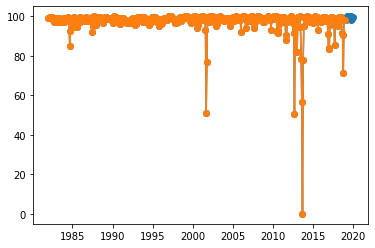

In [5]:
num_x = 5
num_y = 5
print(any(np.isnan(sic[:,num_x,num_y])))
plt.plot(time,sic[:,num_x,num_y],'-o')
plt.plot(time_train,sic_train[0:nmonth-12,num_x,num_y],'-o')

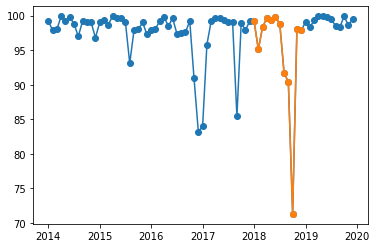

In [6]:
plt.plot(time[nmonth-72:],sic[nmonth-72:,num_x,num_y],'-o')
plt.plot(time_train[nmonth-24:nmonth-12],sic_train[nmonth-24:nmonth-12,num_x,num_y],'-o')

In [7]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
        X, y = list(), list()
        for i in range(len(sequence)):
                # find the end of this pattern
                end_ix = i + n_steps
                # check if we are beyond the sequence
                if end_ix > len(sequence)-1:
                        break
                # gather input and output parts of the pattern
                seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
                X.append(seq_x)
                y.append(seq_y)
        return array(X), array(y)
    
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

def LSTM_sequence_sic(sic, n_steps, dense_num, epoch_num, n_features):
        X = list()
        if any(np.isnan(sic)):
            for i in range(n_steps):
                X_new = float("nan")
                X.append(X_new)
                #print(X_new.shape)
            RMSE = float("nan")
        else:
            if min(sic) == max(sic):
                for i in range(n_steps):
                    X_new = min(sic)
                    X.append(X_new)
                    #print(X_new.shape)
                RMSE = float("nan")
            else:     
                nmonth          = len(sic)
                sic_train       = sic[0:nmonth-n_steps]
                X_SIC, Y_SIC    = split_sequence(sic_train,n_steps)
                X_SIC = X_SIC.reshape((X_SIC.shape[0], X_SIC.shape[1], n_features))
                
                model = Sequential()
                model.add(LSTM(dense_num, activation='relu', input_shape=(n_steps, n_features)))
                model.add(Dense(1))
                model.compile(optimizer='adam', loss='mse')
                model.fit(X_SIC, Y_SIC, epochs=epoch_num, verbose=0)
        
        
                for i in range(n_steps):
                    x_input = sic[nmonth-n_steps*2+i:nmonth-n_steps+i]
                    #print(time[nmonth-n_steps*2+i:nmonth-n_steps+i])
                    x_input = x_input.reshape((1, n_steps, n_features))
                    #print(x_input)
                    X_new = model.predict(x_input, verbose=0)
                    #print('sic            at ', i,'is ', sic[nmonth-n_steps+i])
                    #print('sic prediction at ', i,'is ', X_new)
                    #print('')
                    #input('press return to continue')
                    X.append(X_new[0,0])
                RMSE = sqrt(mean_squared_error(sic[nmonth-n_steps:], X))
        return array(X), RMSE
    
def V1_LSTM_sequence_sic(thk, sic, n_steps, dense_num, epoch_num, n_features):
        X = list()
        if any(np.isnan(sic)) or any(np.isnan(thk)) :
            for i in range(n_steps):
                X_new = float("nan")
                X.append(X_new)
                #print(X_new.shape)
            RMSE = float("nan")
        else:
            if min(sic) == max(sic):
                for i in range(n_steps):
                    X_new = min(sic)
                    X.append(X_new)
                    #print(X_new.shape)
                RMSE = float("nan")
            else:     
                nmonth          = len(sic)
                thk_train       =  thk[0:nmonth-13]
                sic_train       =  sic[1:nmonth-12]

                sic_train1 = sic_train.reshape((len(sic_train), 1))
                thk_train1 = thk_train.reshape((len(thk_train), 1))

                dataset_train = hstack((thk_train1, sic_train1))
                
                n_steps = 12
                
                X_SIC, Y_SIC = split_sequences(dataset_train, n_steps)
                n_features = X_SIC.shape[2]
                
                model = Sequential()
                model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
                model.add(Dense(1))
                model.compile(optimizer='adam', loss='mse')
                model.fit(X_SIC, Y_SIC, epochs=200, verbose=0)
                
                
                
                for i in range(n_steps):
                    thk_input = thk[nmonth-24+i:nmonth-12+i]
                    thk_input1 = thk_input.reshape((len(thk_input), 1))
                    dataset_input = hstack((thk_input1))
                    dataset_input1 = dataset_input.reshape((1, n_steps, n_features))
                    X_new = model.predict(dataset_input1, verbose=0)
                    X.append(X_new[0,0])
                RMSE = sqrt(mean_squared_error(sic[nmonth-n_steps:], X))
        return array(X), RMSE
    
def AR_sequence_sic(sic, n_steps, lagnum):
        X = list()
        if any(np.isnan(sic)):
            for i in range(n_steps):
                X_new = float("nan")
                X.append(X_new)
                #print(X_new.shape)
            RMSE = float("nan")
        else:
            if min(sic) == max(sic):
                for i in range(n_steps):
                    X_new = min(sic)
                    X.append(X_new)
                    #print(X_new.shape)
                RMSE = float("nan")
            else:     
                for i in range(n_steps):
                    sic_train = sic[0:nmonth-n_steps+i]
                    model = AutoReg(sic_train, lags=lagnum)
                    model_fit = model.fit()
                    X_new = model_fit.predict(start=len(sic_train), end=len(sic_train), dynamic=False)
                    #print('sic            at ', i,'is ', sic[nmonth-n_steps+i])
                    #print('sic prediction at ', i,'is ', X_new)
                    #print('')
                    #input('press return to continue')
                    X.append(X_new)
                RMSE = sqrt(mean_squared_error(sic[nmonth-n_steps:], X))
        return array(X), RMSE

In [8]:
for ix in range(sic.shape[1]):
    for jy in range(sic.shape[2]):
        if any(np.isnan(thk[:,ix,jy])) or any(np.isnan(sic[:,ix,jy])) :
            RMSE_ML[ix,jy] = float("nan")
            RMSE_AR[ix,jy] = float("nan")
        else:
            y_hat, RMSE_ML[ix,jy] = V1_LSTM_sequence_sic(thk[:,ix,jy],sic[:,ix,jy],12,50,200,2)
            z_hat, RMSE_AR[ix,jy] = AR_sequence_sic(sic[:,ix,jy],12,24)
            RMSE_ML_AR[ix,jy] = RMSE_ML[ix,jy] - RMSE_AR[ix,jy]
            #if (not np.isnan(RMSE_ML[ix,jy])):
            print('ix=',ix,'jy=',jy)
            print('RMSE_ML=',RMSE_ML[ix,jy],'RMSE_AR=',RMSE_AR[ix,jy],'ML-AR=',RMSE_ML_AR[ix,jy])
            print('')

ix= 0 jy= 0
RMSE_ML= nan RMSE_AR= nan ML-AR= nan

ix= 0 jy= 1
RMSE_ML= nan RMSE_AR= nan ML-AR= nan

ix= 0 jy= 2
RMSE_ML= nan RMSE_AR= nan ML-AR= nan

ix= 0 jy= 3
RMSE_ML= nan RMSE_AR= nan ML-AR= nan

ix= 0 jy= 4
RMSE_ML= nan RMSE_AR= nan ML-AR= nan

ix= 0 jy= 5
RMSE_ML= nan RMSE_AR= nan ML-AR= nan

ix= 0 jy= 6
RMSE_ML= nan RMSE_AR= nan ML-AR= nan

ix= 0 jy= 7
RMSE_ML= nan RMSE_AR= nan ML-AR= nan

ix= 0 jy= 8
RMSE_ML= nan RMSE_AR= nan ML-AR= nan

ix= 0 jy= 9
RMSE_ML= nan RMSE_AR= nan ML-AR= nan

ix= 1 jy= 0
RMSE_ML= nan RMSE_AR= nan ML-AR= nan

ix= 1 jy= 1
RMSE_ML= nan RMSE_AR= nan ML-AR= nan

ix= 1 jy= 2
RMSE_ML= nan RMSE_AR= nan ML-AR= nan

ix= 1 jy= 3
RMSE_ML= nan RMSE_AR= nan ML-AR= nan

ix= 1 jy= 4
RMSE_ML= 2.5965918174242746 RMSE_AR= 2.074849284563305 ML-AR= 0.5217425328609697

ix= 1 jy= 5
RMSE_ML= 0.10401211289815268 RMSE_AR= 0.05878609641444682 ML-AR= 0.04522601648370586

ix= 1 jy= 7
RMSE_ML= 15.45651396183949 RMSE_AR= 10.656408213696619 ML-AR= 4.800105748142871

ix= 2 jy= 2
RMS

In [9]:
print(RMSE_ML)
print('Average of RMSE with MLP = ', nanmean(RMSE_ML))

[[        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan  2.59659182  0.10401211
          nan 15.45651396         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan 16.69189852 15.80288537
          nan         nan         nan         nan]
 [        nan         nan         nan         nan  0.84871649  5.74334165
          nan         nan         nan         nan]
 [        nan  6.56036429         nan 16.63068493  1.62181616  5.33121864
  16.87744304         nan         nan         nan]
 [        nan         nan         nan         nan  7.83953306 13.93962649
   2.87086255         nan         nan         nan]
 [        nan 12.99743334         nan         nan         nan         nan
          nan         nan         nan         nan]


In [10]:
print(RMSE_AR)
print('Average of RMSE with Autoregression = ', nanmean(RMSE_AR))

[[        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan  2.07484928  0.0587861
          nan 10.65640821         nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan]
 [        nan         nan         nan         nan 23.87404551 14.98433825
          nan         nan         nan         nan]
 [        nan         nan         nan         nan  0.51606108  5.4622164
          nan         nan         nan         nan]
 [        nan  6.16693543         nan 19.3510853   0.71800087  3.65324142
  14.54319331         nan         nan         nan]
 [        nan         nan         nan         nan  9.53151969 10.60500669
   0.97237831         nan         nan         nan]
 [        nan 12.8417918          nan         nan         nan         nan
          nan         nan         nan         nan]
 [

In [11]:
#nc_fid.createDimension('num_pixels',10)
#nc_fid.createDimension('num_lines', 10)
ARvariable = nc_fid.createVariable('RMSE_AR', 'float',('num_pixels', 'num_lines'))
MLvariable = nc_fid.createVariable('RMSE_ML', 'float',('num_pixels', 'num_lines'))
ML_AR      = nc_fid.createVariable('RMSE_ML_AR', 'float',('num_pixels', 'num_lines'))
ARvariable[:] = RMSE_AR[:,:]
MLvariable[:] = RMSE_ML[:,:]
ML_AR[:]      = RMSE_ML_AR[:,:]
nc_fid.close()

In [13]:
print('Average of RMSE with ML = ', nanmean(RMSE_ML))
print('Average of RMSE with Autoregression = ', nanmean(RMSE_AR))

Average of RMSE with ML =  8.36637578874875
Average of RMSE with Autoregression =  8.011211635566433
